In [1]:
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize      import fsolve, curve_fit
from scipy.integrate     import odeint, quad
from scipy.interpolate   import interp1d
from scipy.misc          import derivative
import scipy.constants   as const
import sympy             as sp
sp.init_printing()
import glob
import math
import alpaca_trade_api as tradeapi
from alpaca_trade_api import StreamConn
import threading
import time
import datetime
import logging
import argparse
import pandas as pd
ALPACA_BASE_URL ='https://paper-api.alpaca.markets';
KEY = 'PKRK5NERF9UZD8JKN80K'
SCRKEY = 'A6tH776v1Jt99Qas59V4PlXlkH9dpeeaRycyEyF9'

from lxml import html
import requests
import json
import argparse
from collections import OrderedDict

import talib as tlb
import scipy.stats as stat
import schedule
#from datetime import datetime

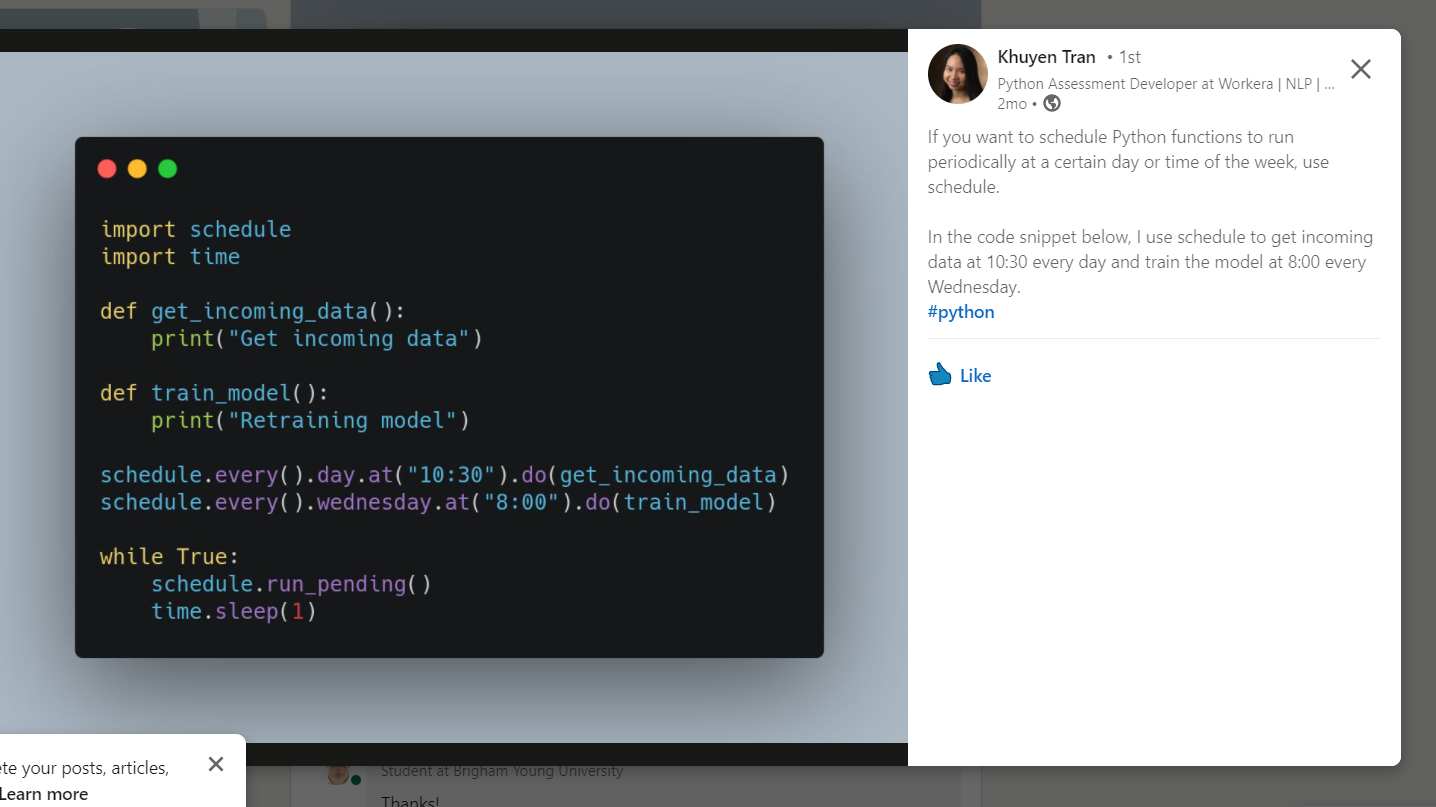

### VOLATILITY

In [ ]:
#DICTIONARY
#h = high price
#l = low price of the time interval
#m_day = the 

'''IS IT BETTER TO HAVE A DIFFERENT PERIOD/INTERVAL TO FIND BEST STOCKS??'''
start = time.time()
def volatility(symbol):

    
    '''RETRIEVING HIGH AND LOW DATA POINTS'''
    print('Getting Data')             #! DO I WANT A LONGER CONSIDERING PERIOD???
    api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
    sb     = api.get_barset(symbol, '15Min', limit = 400).df   
    h      = sb[symbol]['high']
    l      = sb[symbol]['low']
    
    '''CALCULATING THE VOLATILITY'''
    m_day = h-l   #!! CHECK THIS LINE
    M_ave = sum(m_day)/len(m_day)
    deviation = []
    for m in m_day:
        deviation.append(((m-M_ave)/M_ave*100)**2)  
    volatility = sum(deviation)/len(m_day)/1000                  
    return volatility


def EMA_M(symbol):
    '''RETRIEVING HIGH AND LOW DATA POINTS'''
    print('Getting Data')             #! DO I WANT A LONGER CONSIDERING PERIOD???
    api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
    sb     = api.get_barset(symbol, '15Min', limit = 400).df   
    h      = sb[symbol]['high']
    l      = sb[symbol]['low']
    
    #return Price_now-EMA_50
############################################
'''!INSESRT SCHEDULER HERE'''
api = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
stocks = api.list_assets(status='active')

NYSE_assets_full = [i for i in stocks if i.exchange=='NYSE' or 'NASDAQ']

NYSE = []
for i in NYSE_assets_full:
    NYSE.append(i.symbol)
###############################################
volatility_dict = {}
for s in NYSE:
    try:
        volatility_dict[s] = volatility(s)
        print(f'Volatility for {s} = {volatility_dict[s]}')
        print()
    except:
        print(f'Failed to get volatility for {s}')
#################################################
import pandas as pd
for i in dict(volatility_dict):
    if pd.notnull(volatility_dict[i])== False:
        del volatility_dict[i] 
    #if EMA_M(volatility_dict[i])<0:
    #    del volatility_dict[i]
################################################
LIST = []
LIST_sort = []
for i in volatility_dict:
    member = [i,volatility_dict[i]]
    LIST.append(member)
    LIST_sort.append(volatility_dict[i])
b = sorted(LIST_sort)

List_sorted = []
for i in range(len(b)):
    #print(i)
    INDEX = LIST_sort.index(b[i])
    #print(INDEX)
    List_sorted.append((LIST[INDEX]))
print('sorted list')
print(List_sorted)
#improving the picker, see which stocks perform best and notice what they have in common, volume, what do the best trades have in common?  
end = time.time()
print(f'Time elapsed={end-start}')

In [ ]:
picked = List_sorted[-40:-1]
df     = pd.DataFrame(picked)
with open('picked.csv', 'w') as file:
    df.to_csv('picked.csv')
    

### QUANTITY STOCKS TO BUY

In [2]:
#N is the number of stocks we should buy based on the close price and the amount of cap
#Money is the amount of cash not including 
'''!buy less of a stock if I already have some of that stock'''
def QUANTITY(symbol,CLOSE,L0 = 110000):
    api = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
    account = api.get_account()
    
    try:
        position = api.get_position(symbol)  #will this give me other useful data?
        quantity = position.qty
    except:
        quantity = 0
    
    γ       = (L0*0.3-int(quantity)*CLOSE)/(L0*0.3)
    MONEY        = int(float(account.buying_power))*γ
    MONEY_TO_BUY = 0.0025*MONEY   
    N            = math.ceil(MONEY_TO_BUY/CLOSE)
    if MONEY<20000:
        N=0
    return N

###  BOT

In [3]:
def glass_ceiling_bot(symbol,period=20,num=100,printing=True,plotting=False,bypass=False):
    #CHECKING THE TIME
    api    = tradeapi.REST(KEY, SCRKEY, ALPACA_BASE_URL, api_version='v2')
    clock = api.get_clock()

    if clock.is_open or bypass==True:
        sb     = api.get_barset(symbol, 'minute', limit = num).df
        prices = {}
        A      = ['close']
        for a in A:
            prices[a]=sb[symbol][a]
        #!delete data points outside of market open
        for i in range(len(prices['close'])):
            if prices['close'][i]==0:
                prices['close'][i]=prices['close'][i-1]
        
        #BOLLINGER BANDS    
        up,mid,lwr = tlb.BBANDS(prices['close'],period,nbdevup=1.8,nbdevdn=1.2,matype=1)
        up,mid,lwr = up[period:],mid[period:],lwr[period:]
        
        #RSI
        RSI = tlb.RSI(prices['close'], timeperiod=period)
        RSI = RSI[period:]
        levels = [1,5,10,25,50,75,90,95,99]
        B = stat.scoreatpercentile(RSI, [1,5,10,25,50,75,90,95,99])
        RSI_level = []
    
        for current in RSI:
            RSI_level.append(stat.percentileofscore(RSI,current))
    
        #QUANTITY 
        try:
            position = api.get_position(symbol)  #will this give me other useful data?
            quantity = int(position.qty)
        except:
            quantity = 0        
    
        #NUMBER OF STOCKS TO BUY
        quantity_buy = QUANTITY(symbol,prices['close'][-1])
    
#BOT           
        TIME = time.localtime()
        minute = TIME.tm_min
        hr = TIME.tm_hour 
        buy=np.nan
        sell=np.nan

        #After 130 sell
        if 14>hr>=13 and minute>57:
            api.submit_order(symbol, quantity, 'sell', 'market', 'day')
        else:
            #buy
            if up[-1]<=prices['close'][-1] and RSI_level[-1]<80 and quantity_buy>0:  #notice that both buys might have the same q buy
                api.submit_order(symbol, quantity_buy, 'buy', 'market', 'day')
                print(colored(f'bought {quantity_buy} stocks of {symbol} at', prices['close'][-1], '$/share','gold'))
                buy=prices['close'][-1]  
                
            #buy
            if RSI_level[-1]<20 and mid[-1]<=prices['close'][-1] and quantity_buy>0:
                api.submit_order(symbol, quantity_buy, 'buy', 'market', 'day')
                print(f'bought {quantity_buy} stocks of {symbol} at', prices['close'][-1], '$/share')
                buy=prices['close'][-1]
                
            #sell
            if prices['close'][-1]<lwr[-1] and quantity>0: #CONSIDER A different n stdv above vs below
                api.submit_order(symbol, quantity, 'sell', 'market', 'day')
                print(f'sold {quantity} stocks of {symbol} at', prices['close'][-1],'$/share')
                sell=prices['close'][-1]
    
        '''!I SHOULD SELL AT THE END OF THE DAY'''
            
        '''!DATA FRAME WITH TIME, TRIGGER, NUMBER OF BOUGHT AND SOLD, TICKER, RSI, RSI level'''
        name = f'{symbol}.csv'
        try: #!add the number of stocks traded
            #print('try')
            df1=pd.read_csv(name,index_col=False)
            fileVariable = open(name, 'r+')
            fileVariable.truncate(0)
            fileVariable.close()
            df2=pd.DataFrame([[buy,sell]],columns=['buy','sell'])
            df_new=pd.concat([df1,df2],ignore_index=False,join='inner')
            df_new.to_csv(name)
        except:
            f= open(name,"w+")
            #print('except')
            A = np.zeros((num,2))
            A[:]=np.nan
            df1=pd.DataFrame(A, columns=['buy','sell'],index=None)
            df2=pd.DataFrame([[buy,sell]],columns=['buy','sell'])
            df_new=pd.concat([df1,df2],axis=0,ignore_index=True,join='inner')
            
            df_new.to_csv(name)
        print(len(df_new['buy'][-(num-period):]))
            
        '''!LIVE PLOTS THAT SHOW SIMULATOR DATA WITH THE PRINTS NICELY DONE AND POSSIBLE ADJUSTED TO BE DYNAMIC, BUY/SELL IN PRICE PLOT '''
        if plotting:
            tf = num-period
            w,h = 20,7
            t = np.linspace(0,tf,tf)
            plt.figure(figsize=(w,h))
            ax1=plt.subplot(211)
            plt.title(symbol,fontsize=24)
            plt.plot(t,prices['close'][period:],label='close')
            plt.plot(t,up,'1',color='green',label='up',markersize=10)
            plt.plot(t,mid,'.',color='black',label='mid',markersize=10)
            plt.plot(t,lwr,'2',color='red',label='low',markersize=10)
            
            plt.plot(t,df_new['buy'][-(num-period):],'*',label='BUY',markersize=15,color='gold')
            plt.plot(t,df_new['sell'][-(num-period):],'*',label='SELL',markersize=15,color='black')
            
            plt.legend(fontsize=20)
            plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
            plt.yticks(fontsize=20)
            plt.xlim(period,t[-1]+10)
            plt.setp(ax1.get_xticklabels(),fontsize=20,visible=False)
            plt.grid()
            plt.show();
            
            
            plt.figure(figsize=(w,h))
            ax2=plt.subplot(212,sharex=ax1)
            plt.plot(t,RSI_level,label='RSI')
            for i,b in enumerate(B,0):
                plt.plot(t,np.ones(len(t))*b,label=f'{levels[i]} % Percentil' )
            plt.xticks(np.linspace(0,len(up),20),fontsize=20,rotation=45)
            plt.yticks(fontsize=20)
            plt.xlim(period,t[-1]+10)
            #plt.legend(fontsize=20)
            plt.grid();
            plt.show();
            plt.setp(ax2.get_xticklabels(),visible=True);

    else:
        print(f'market is closed for {symbol}')
        time.sleep(360)
        
        '''!FILE TO SAVE DATA FOR THE DAY IN AN ORGANIZED MANNER'''


### CALLER

In [ ]:
glass_ceiling_bot('FXF',plotting=True)

In [5]:
stock_list = pd.read_csv('picked.csv', names=['index','symbol','index_2','volatility'])
stocks=stock_list['symbol']
stocks=stocks.drop(labels=[0],axis=0)
stocks[-100:-1]

1     DRSK
2     ONEQ
3      EWX
4     SPTI
5      UZE
6      FGD
7     JEPI
8      DGS
9     NULV
10    EMHY
11    SCHZ
12    FCOM
13     IYH
14    SUSL
15    SMMD
16    SPHY
17     FIW
18    IPAC
19    IQDF
20    PFXF
21    JAGG
22    FBND
23    QEFA
24     AOM
25     SHM
26    BSCT
27    DFAE
28    IBDT
29    BSJP
30    GNMA
31    TIPZ
32     FMB
33    BSJO
34     SUB
35    BSCR
36     FXF
37    BSCM
38    SCHJ
Name: symbol, dtype: object

In [4]:
'''READING THE MOST VOLATILE STOCKS'''
stock_list = pd.read_csv('picked.csv', names=['index','symbol','index_2','volatility'])
stocks=stock_list['symbol']
stocks=stocks.drop(labels=[0],axis=0)


#stocks = ['BSCM','FXF','BSCR','BSJO','GNMA','BSJP','DFAE','IBDT','DFAE','GNMA','TSLA','TIPZ','IGA','DBE','ERUS','IUSG','IBDD',
         #'SCHM','PFL','DGRW','FTXO','NUSC','ACP','PRN','PFFA','RPG','BSL','EEMA','IBDV']
#stocks = stocks[0:3]
'''CALLING THE BOT'''
Time = []
while True:
    for s in stocks:
        try:
            glass_ceiling_bot(s,plotting=True)
        except:
            print(f'failed to observe {s}')
        Time.append( time.time())
    time.sleep(60-(Time[-1]-Time[-2]))
    #https://stackoverflow.com/questions/8213522/when-to-use-cla-clf-or-close-for-clearing-a-plot-in-matplotlib

market is closed for DRSK
market is closed for ONEQ
market is closed for EWX
market is closed for SPTI
market is closed for UZE
market is closed for FGD
market is closed for JEPI
market is closed for DGS
market is closed for NULV
market is closed for EMHY
market is closed for SCHZ
market is closed for FCOM
market is closed for IYH
market is closed for SUSL
market is closed for SMMD
market is closed for SPHY
market is closed for FIW
market is closed for IPAC
market is closed for IQDF
market is closed for PFXF
market is closed for JAGG
market is closed for FBND
market is closed for QEFA
market is closed for AOM
market is closed for SHM
market is closed for BSCT
market is closed for DFAE
market is closed for IBDT
market is closed for BSJP
market is closed for GNMA
market is closed for TIPZ
market is closed for FMB
market is closed for BSJO
market is closed for SUB
market is closed for BSCR
market is closed for FXF
market is closed for BSCM
market is closed for SCHJ
market is closed for BI

ValueError: sleep length must be non-negative

In [ ]:
t = np.linspace(0,100,101)
a = t*2
b = t**2


fig, axs = plt.subplots(3, 1, sharex=True)
fig.subplots_adjust(hspace=0)
plt.subplot(2,1,1)
plt.plot(t,a, label='a')
plt.subplot(2,1,2)
plt.plot(t,b, label='b')
plt.legend();